In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
import tensorflow as tf

C:\Users\Acer\Anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Acer\Anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Acer\Anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Acer\Anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\f

In [3]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True)) #To check if its using GPU

In [4]:
df = pd.read_csv('ONGC.csv')
df.shape

(754, 13)

In [5]:
df.isnull().sum()

Date                         0
Open Price                   0
High Price                   0
Low Price                    0
Close Price                  0
WAP                          0
No.of Shares                 0
No. of Trades                0
Total Turnover (Rs.)         0
Deliverable Quantity         0
% Deli. Qty to Traded Qty    0
Spread High-Low              0
Spread Close-Open            0
dtype: int64

In [6]:
df.dropna(inplace = True)
df.reset_index(drop = True, inplace = True)
df.isnull().sum()

Date                         0
Open Price                   0
High Price                   0
Low Price                    0
Close Price                  0
WAP                          0
No.of Shares                 0
No. of Trades                0
Total Turnover (Rs.)         0
Deliverable Quantity         0
% Deli. Qty to Traded Qty    0
Spread High-Low              0
Spread Close-Open            0
dtype: int64

In [7]:
len(df['Low Price'])
Train = df.iloc[:501,:]
Test = df.iloc[501:,:]
print(Train.shape)
print(Test.shape)
Test.head()

(501, 13)
(253, 13)


,Date,Open Price,High Price,Low Price,Close Price,WAP,No.of Shares,No. of Trades,Total Turnover (Rs.),Deliverable Quantity,% Deli. Qty to Traded Qty,Spread High-Low,Spread Close-Open
501,10-Oct-18,146.00,151.35,146.00,148.65,149.280545,629957,7440,94040324,133252,21.15,5.35,2.65
502,11-Oct-18,147.70,159.60,147.00,152.90,153.957990,1109341,9434,170791911,174362,15.72,12.60,5.20
503,12-Oct-18,154.75,157.80,154.15,157.20,156.056534,324091,3328,50576518,65349,20.16,3.65,2.45
504,15-Oct-18,157.95,160.95,156.85,160.00,159.343773,358361,6592,57102594,117214,32.71,4.10,2.05
505,16-Oct-18,162.10,166.70,161.15,165.50,164.221638,509322,6160,83641693,127766,25.09,5.55,3.40


In [8]:
class Agent:

    LEARNING_RATE = 1e-3
    LAYER_SIZE = 256
    GAMMA = 0.9
    OUTPUT_SIZE = 3

    def __init__(self, state_size, window_size, trend,trend_test, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.trend_test = trend_test
        tf.reset_default_graph()
        self.X = tf.placeholder(tf.float32, (None, self.state_size))
        self.REWARDS = tf.placeholder(tf.float32, (None))
        self.ACTIONS = tf.placeholder(tf.int32, (None))
        feed_forward = tf.layers.dense(self.X, self.LAYER_SIZE, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed_forward, self.OUTPUT_SIZE, activation = tf.nn.softmax)
        
        input_y = tf.one_hot(self.ACTIONS, self.OUTPUT_SIZE)
        loglike = tf.log((input_y * (input_y - self.logits) + (1 - input_y) * (input_y + self.logits)) + 1)
        rewards = tf.tile(tf.reshape(self.REWARDS, (-1,1)), [1, self.OUTPUT_SIZE])
        self.cost = -tf.reduce_mean(loglike * (rewards + 1)) 
        self.optimizer = tf.train.AdamOptimizer(learning_rate = self.LEARNING_RATE).minimize(self.cost)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
    
    def predict(self, inputs):
        return self.sess.run(self.logits, feed_dict={self.X:inputs})
    
    def get_state_train(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    
    def get_state_test(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend_test[d : t + 1] if d >= 0 else -d * [self.trend_test[0]] + self.trend_test[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    
    def discount_rewards(self, r):
        discounted_r = np.zeros_like(r)
        running_add = 0
        for t in reversed(range(0, r.size)):
            running_add = running_add * self.GAMMA + r[t]
            discounted_r[t] = running_add
        return discounted_r
    
    def get_predicted_action(self, sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)
    
    def buy(self, initial_money,Validate_profit):
        Date = Test.Date
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        trade_act = []
        trade_act = []  
        Dates = []      
        Profit = []     
        Money  = []
        state = self.get_state_test(0)
        for t in range(0,len(self.trend_test)-1, self.skip):
            action = self.get_predicted_action(state)
            next_state = self.get_state_test(t + 1)
            
            
            if action == 1 and initial_money >= self.trend_test[t] and t < (len(self.trend_test) - self.half_window):
                inventory.append(self.trend_test[t])
                initial_money -= self.trend_test[t]
                states_buy.append(t)
                trade_act.append('buy')   
                Dates.append(Date[501+t])  
                Profit.append(initial_money - starting_money)  
                Money.append(initial_money) 
#                 print('day %d: buy 1 unit at price %f, total balance %f'%
#                       (t, self.trend_test[t], initial_money))
                
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend_test[t]
                states_sell.append(t)
                trade_act.append('sell')   
                Dates.append(Date[501+t]) 
                Profit.append(initial_money - starting_money)  
                Money.append(initial_money)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
#                 print('day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'% 
#                      (t, close[t], invest, initial_money))
            elif action == 0:
                trade_act.append('hold')   
                Dates.append(Date[501+t])  
                Profit.append(0) 
                Money.append(initial_money)
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        Validate_profit.append(total_gains)
        return states_buy, states_sell, total_gains, invest,Validate_profit,trade_act,Dates,Profit,Money
        
    
    def train(self, iterations, checkpoint, initial_money):
        iters = []
        Train_profit = []
        Validate_profit = []
        for i in range(iterations):
            close = trend
            Date = Train.Date
            ep_history = []
            total_profit = 0
            step_profit = []
            inventory = []
            iters.append(i+1)
            state = self.get_state_train(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.get_predicted_action(state)
                next_state = self.get_state_train(t + 1)
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= close[t]
                
                elif action == 2 and len(inventory):
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                                
                ep_history.append([state,action,starting_money,next_state])
                state = next_state
            ep_history = np.array(ep_history)
            ep_history[:,2] = self.discount_rewards(ep_history[:,2])
            cost, _ = self.sess.run([self.cost, self.optimizer], feed_dict={self.X:np.vstack(ep_history[:,0]),
                                                    self.REWARDS:ep_history[:,2],
                                                    self.ACTIONS:ep_history[:,1]})
            gains = starting_money - initial_money 
            Train_profit.append(gains)
            states_buy, states_sell, total_gains, invest,Validate_profit,trade_act,Dates,Profit,Money = agent.buy(initial_money,Validate_profit)            
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3,total money: %f,Train_profit: %f,Validate_profit:%f'% #removed cost
                      (i + 1, total_profit,starting_money,gains,total_gains))
            if total_gains >= 100 :
                break
                print("Breaking the loop validate profit:",total_gains)
        
        return Train_profit,Validate_profit,iters

In [12]:
trend = Train['Close Price'].values.tolist()
trend_test = Test['Close Price'].values.tolist()
initial_money = 10000
window_size = 30
skip = 1
agent = Agent(state_size = window_size,
             window_size = window_size,
             trend = trend,
            trend_test = trend_test,
             skip = skip)


Train_profit,Validate_profit,iters = agent.train(iterations = 50, checkpoint = 1, initial_money = initial_money)

epoch: 1, total rewards: -562.600000.3,total money: 5493.250000,Train_profit: -4506.750000,Validate_profit:68.100000
epoch: 2, total rewards: 39.250000.3,total money: 10039.250000,Train_profit: 39.250000,Validate_profit:84.100000
epoch: 3, total rewards: 7.550000.3,total money: 10007.550000,Train_profit: 7.550000,Validate_profit:-1785.050000
epoch: 4, total rewards: -805.200000.3,total money: 1983.500000,Train_profit: -8016.500000,Validate_profit:-3657.100000
epoch: 5, total rewards: -740.800000.3,total money: 1273.500000,Train_profit: -8726.500000,Validate_profit:-6538.850000
epoch: 6, total rewards: -1587.500000.3,total money: 1070.850000,Train_profit: -8929.150000,Validate_profit:-7596.850000
epoch: 7, total rewards: -2110.750000.3,total money: 1086.400000,Train_profit: -8913.600000,Validate_profit:-6983.650000
epoch: 8, total rewards: -1371.300000.3,total money: 1097.000000,Train_profit: -8903.000000,Validate_profit:-6486.250000
epoch: 9, total rewards: -1782.350000.3,total money: 

# Testing

In [13]:
states_buy, states_sell, total_gains, invest,Validate_profit,trade_act,Dates,Profit,Money = agent.buy(initial_money,Validate_profit) #change

In [16]:
iters.append(30)

In [17]:
ONGC_Model_2 = pd.DataFrame({'Epochs':iters,'ONGC Profit': Validate_profit})#'Train Profit':Train_profit
ONGC_Model_2.to_csv('Models/ONGC/ONGC_Model_2.csv')
ONGC_Prediction_1 = pd.DataFrame({"Date":Dates,"Actions":trade_act,"Profit":Profit,"Current Money":Money})
ONGC_Prediction_1.to_csv("Models/ONGC/ONGC_Prediction_1.csv")

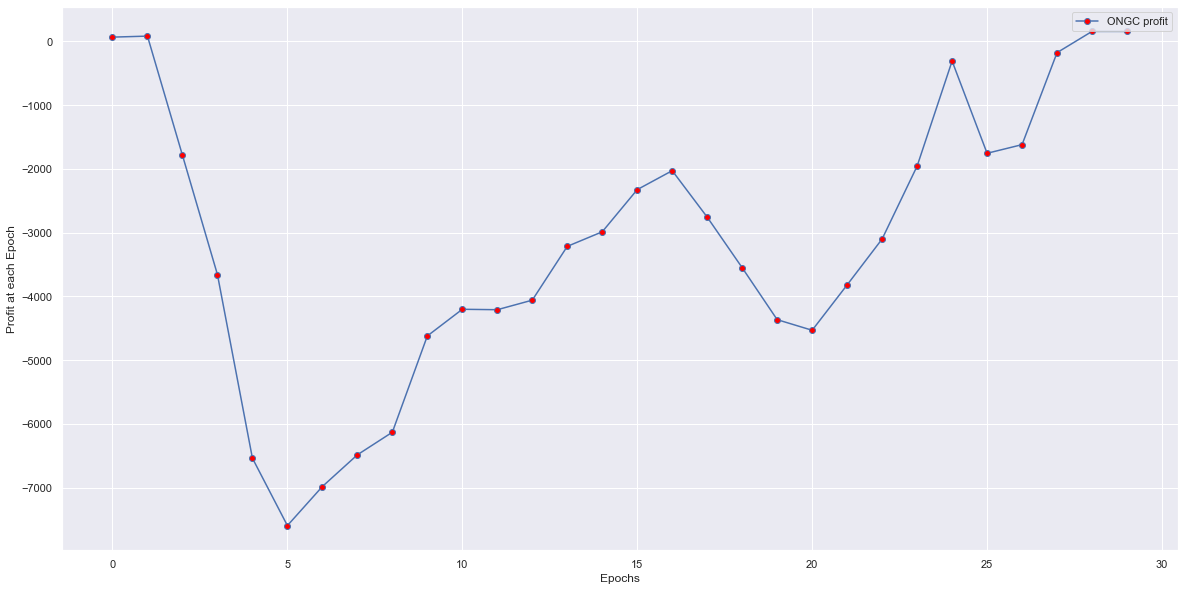

In [18]:
fig = plt.figure(figsize = (20,10))
#plt.plot(Train_profit,marker='o', markerfacecolor='blue',label = 'Train profit')
plt.plot(Validate_profit,marker='o', markerfacecolor='red',label = 'ONGC profit')
plt.xlabel('Epochs')
plt.ylabel('Profit at each Epoch')
plt.legend()
plt.savefig('Models/ONGC/ONGC_Model_2')
plt.show()

In [19]:
len(trend_test)

253

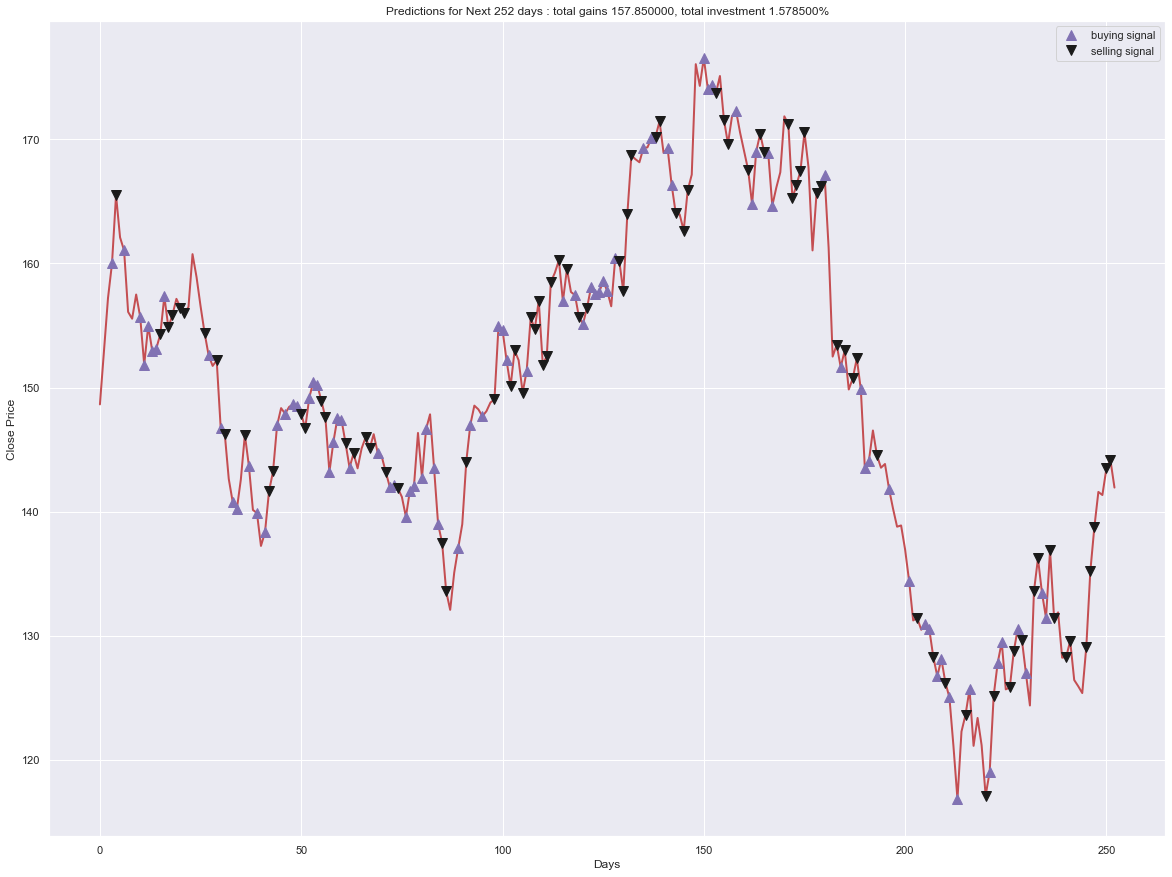

In [20]:
fig = plt.figure(figsize = (20,15))
plt.plot(trend_test, color='r', lw=2.)
plt.plot(trend_test, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(trend_test, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('Predictions for Next 252 days : total gains %f, total investment %f%%'%(total_gains, invest))
plt.xlabel('Days')
plt.ylabel('Close Price')
plt.legend()
plt.savefig('Models/ONGC/ONGC Chart')
plt.show()

In [ ]:
Performance = pd.read_csv('Models/Best/Performance.csv')

In [ ]:
fig = plt.figure(figsize = (20,10))
plt.plot(Performance.Close,marker='o', markerfacecolor='blue',label = 'Close')
plt.plot(Performance.High,marker='o', markerfacecolor='red',label = 'High')
plt.plot(Performance.Low,marker='o', markerfacecolor='Green',label = 'Low')
plt.plot(Performance.Open,marker='o', markerfacecolor='Yellow',label = 'Open')
plt.xlabel('Days')
plt.ylabel('Total Profit')
plt.legend()
plt.savefig('Models/SBI/Performance')
plt.show()


In [ ]:
Year_Performance = pd.read_csv('Models/Best/Year_performance.csv')
Year_Performance.head()

In [ ]:
Year_Performance['1 year']

In [ ]:
fig = plt.figure(figsize = (20,10))
plt.plot(Year_Performance['1 year'],marker='o', markerfacecolor='blue',label = '1 year')
plt.plot(Year_Performance['2 years'],marker='o', markerfacecolor='red',label = '2 years')
plt.plot(Year_Performance['3 years'],marker='o', markerfacecolor='Green',label = '3 years')
plt.plot(Year_Performance['4 years'],marker='o', markerfacecolor='Yellow',label = '4 years')
plt.xlabel('Days')
plt.ylabel('Total Profit')
plt.legend()
plt.savefig('Models/Best/Year_Performance')
plt.show()


# Testing

In [ ]:
fig = plt.figure(figsize = (15,5))
plt.plot(trend_test, color='r', lw=2.)
plt.plot(trend_test, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(trend_test, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('Predictions for Next 251 days : total gains %f, total investment %f%%'%(total_gains, invest))
plt.xlabel('Days')
plt.ylabel('Close Price')
plt.legend()
plt.show()